In [1]:
import tensorflow as tf

2023-08-24 01:16:46.259662: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 01:16:46.308525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 01:16:47.608974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc
from scipy.ndimage import binary_erosion
from IPython import display
import datetime

import model

In [4]:
subjects = [ f.name for f in os.scandir('./Data') if f.is_dir() and f.name != '.ipynb_checkpoints']

# subjects = ['390645', '120111']

e_or_o = 1

p_size_i = 7
p_size_o = 4

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341']


In [5]:
# input_layer = tf.keras.Input(shape=(32, 32, 32, 36))
# output_layer = model.unet3d(input_layer, 36)

# generator = tf.keras.Model(input_layer, output_layer)
generator = model.simple_generator(30,22,2*p_size_i+e_or_o)
discriminator = model.simple_discriminator(22,2*p_size_o+e_or_o, layer_num=3)

(None, 9, 9, 9, 22)
(None, 1)


2023-08-24 01:16:50.073957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 01:16:50.094492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 01:16:50.094619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
print(generator.summary())
print(discriminator.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 13, 13, 50)    40550     
                                                                 
 batch_normalization (Batch  (None, 13, 13, 13, 50)    200       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 13, 13, 13, 50)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 13, 13, 13, 100)   5100      
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 13, 100)   400       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 13, 13, 13, 100)   0

In [7]:
subjects_lr = []
subjects_hr = []
subjects_masks = []

subjects_preproc_values_lr = []
subjects_preproc_values_hr = []

subjects_t1_preproc_values = []

for subj in subjects:

    h4_imgs = []
    h4_imgs_lr = []
    dti_imgs = []
    dti_imgs_lr = []

    # DTI normalisation metrics pre-normalisation (storing max and min values in the mask) - Store for HR only
    dti_preprocs_hr = np.zeros((6,2))
    dti_preprocs_lr = np.zeros((6,2))

    print("Loading Subject {}".format(subj))
    
    for i in range(1,9):
    
        dti_data = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())
        dti_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_lowres_2_{}.nii".format(subj,i)).get_fdata())
    
        # if i > 1:
        #     dti_data[dti_imgs[0] < 0] = 0
        #     dti_data_lr[dti_imgs[0] < 0] = 0
    
        dti_imgs.append(dti_data)
        dti_imgs_lr.append(dti_data_lr)
    
        dti_data = None
        dti_data_lr = None
    
    for i in range(1,25):
    
        h4_data = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
        h4_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_lowres_2_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
    
        # if i > 1:
        #     h4_data[h4_data[0] < 0] = 0
        #     h4_data_lr[h4_data[0] < 0] = 0
        
        h4_imgs.append(h4_data)
        h4_imgs_lr.append(h4_data_lr)
    
        h4_data = None
        h4_data_lr = None
    
    h4_imgs = np.array(h4_imgs).transpose((1,2,3,0))
    h4_imgs_lr = np.array(h4_imgs_lr).transpose((1,2,3,0))
    
    dti_imgs = np.array(dti_imgs).transpose((1,2,3,0))
    dti_imgs_lr = np.array(dti_imgs_lr).transpose((1,2,3,0))
    
    mask = h4_imgs[...,0]

    binmask = np.zeros(mask.shape)

    binmask[mask >= 0] = 1

    mask = binary_erosion(binmask, structure=np.ones((5,5,5),np.uint8),iterations = 1)

    binmask = None

    # Calculate DTI ranges and normalise to range [0,1]
    for i in range(2,8):

        dti_preprocs_lr[i-2,:] = np.array([np.min(mask*dti_imgs_lr[...,i]), np.max(mask*dti_imgs_lr[...,i])])
        dti_imgs_lr[mask>0, i] = (dti_imgs_lr[mask>0, i] - dti_preprocs_lr[i-2,0] + 0.0001) / (dti_preprocs_lr[i-2,1] - dti_preprocs_lr[i-2,0])
        dti_imgs_lr[mask==0, i] = 0

        dti_preprocs_hr[i-2,:] = np.array([np.min(mask*dti_imgs[...,i]), np.max(mask*dti_imgs[...,i])])
        dti_imgs[mask>0, i] = (dti_imgs[mask>0, i] - dti_preprocs_hr[i-2,0] + 0.0001) / (dti_preprocs_hr[i-2,1] - dti_preprocs_hr[i-2,0])
        dti_imgs[mask==0, i] = 0


    t1w = nib.load("Data/{}/T1w/Diffusion/t1w.nii".format(subj))
    
    t1w_data = np.array(t1w.get_fdata())
    
    t1w_data_format = np.concatenate(
        (t1w_data[::2,::2,::2, None], t1w_data[::2,::2,1::2, None],
         t1w_data[::2,1::2,::2, None], t1w_data[::2,1::2,1::2, None],
         t1w_data[1::2,::2,::2, None], t1w_data[1::2,::2,1::2, None],
         t1w_data[1::2,1::2,::2, None], t1w_data[1::2,1::2,1::2, None]),
        axis=-1)

    t1w_preprocs = np.array([np.min(t1w_data_format*mask[...,None]), np.max(t1w_data_format*mask[...,None])])
    
    subjects_t1_preproc_values.append(t1w_preprocs)    
    t1w_data_format[mask>0, :] = (t1w_data_format[mask>0, :] - t1w_preprocs[0] + 0.0001) / (t1w_preprocs[1] - t1w_preprocs[0])

    subjects_preproc_values_lr.append(dti_preprocs_lr)
    subjects_preproc_values_hr.append(dti_preprocs_hr)

    # lowres_input = np.concatenate((dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    # hires_output = np.copy(dti_imgs[...,2:])
    
    lowres_input = np.concatenate((h4_imgs_lr[...,2:], t1w_data_format), axis=-1)
    hires_output = np.copy(h4_imgs[...,2:])

    subjects_lr.append(lowres_input)
    subjects_hr.append(hires_output)
    subjects_masks.append(mask)


Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341


In [8]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# cross_entropy_gen = tf.keras.losses.BinaryCrossentropy()
# cross_entropy_disc = tf.keras.losses.BinaryCrossentropy()

# def discriminator_loss(real_output, fake_output):
#     real_loss = tf.reduce_mean(cross_entropy_gen(tf.ones_like(real_output), real_output))
#     fake_loss = tf.reduce_mean(cross_entropy_gen(tf.zeros_like(fake_output), fake_output))
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return tf.reduce_mean(cross_entropy_gen(tf.ones_like(fake_output), fake_output))

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

LAMBDA = 10

def generator_loss(disc_generated_output, gen_output, target):
  # gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  gan_loss = tf.reduce_mean(loss_object(tf.ones_like(disc_generated_output), disc_generated_output))

  # Mean squared error
  l2_loss = tf.reduce_mean(tf.square(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l2_loss)

  return total_gen_loss, gan_loss, l2_loss

In [9]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50*2000,
    decay_rate=0.1
)

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

gen_loss_metric = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
# gen_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy('gen_accuracy')

disc_loss_metric = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = './logs/ganlogslambda{}/'.format(LAMBDA) + current_time + '/train'
summary_writer = tf.summary.create_file_writer(log_dir)

In [11]:
@tf.function
def train_step(lr_patch, hr_patch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(lr_patch, training=True)
    
    real_output = discriminator(hr_patch, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, hr_patch)
    disc_loss = discriminator_loss(real_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  # with summary_writer.as_default():
  #   tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
  #   tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
  #   tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
  #   tf.summary.scalar('disc_loss', disc_loss, step=step)

  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

# @tf.function
# def train_step(lr_patch, hr_patch):

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#       generated_images = generator(lr_patch, training=True)

#       real_output = discriminator(hr_patch, training=True)
#       fake_output = discriminator(generated_images, training=True)

#       gen_loss = generator_loss(fake_output)
#       disc_loss = discriminator_loss(real_output, fake_output)

#     gen_loss_metric(gen_loss)
#     # gen_accuracy_metric(hr_patch, generated_images)

#     disc_loss_metric(disc_loss)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#     return gen_loss, disc_loss
    
# @tf.function
# def train_step_gen(lr_patch, hr_patch):

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

#         generated_images = generator(lr_patch, training=True)

#         real_output = discriminator(hr_patch, training=False)
#         fake_output = discriminator(generated_images, training=False)

#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)

#     gen_loss_metric(gen_loss)
#     # gen_accuracy_metric(hr_patch, generated_images)

#     disc_loss_metric(disc_loss)
    
#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
#     return gen_loss, disc_loss

# @tf.function
# def train_step_disc(lr_patch, hr_patch):

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

#         generated_images = generator(lr_patch, training=False)

#         real_output = discriminator(hr_patch, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)

#     gen_loss_metric(gen_loss)
#     # gen_accuracy_metric(hr_patch, generated_images)

#     disc_loss_metric(disc_loss)

#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#     return gen_loss, disc_loss

In [12]:
def train(data, epochs):

  gen_train_mode = False

  best_cost = np.Inf

  step_count = data[0].shape[0]//4
    
  for epoch in range(epochs):

    if (((epoch+1) % 2) == 0):
        gen_train_mode = not gen_train_mode
      
    start = time.time()

    print("Epoch: {}".format(epoch+1))

    print("Learning rate:", generator_optimizer.learning_rate.numpy())

    total_cost = 0.0

    # [sel_indices, subjects_lr, subjects_hr, subjects_masks]

    randsels = np.random.choice(data[0].shape[0], step_count)

    lr_patches = []
    hr_patches = []

    for prog, index in enumerate(tqdm(randsels)):

        if (prog+1) % 8 != 0 or prog == (len(randsels) - 1):

            (s, i, j, k) = data[0][index]
        
            lr_patch = np.copy(data[1][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, :]) * \
            np.copy(data[3][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, None])
                               
        
            hr_patch = np.copy(data[2][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, :]) * \
            np.copy(data[3][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, None])

            lr_patches.append(lr_patch)
            hr_patches.append(hr_patch)
            
            continue
        
        else:
            lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
            hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)
    
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(lr_patches, hr_patches)
    
            total_cost = total_cost + gen_l1_loss
    
            # if gen_train_mode:
            #     g_loss, d_loss = train_step_gen(lr_patches, hr_patches)
            # else:
            #     g_loss, d_loss = train_step_disc(lr_patches, hr_patches)
    
            with summary_writer.as_default():
                tf.summary.scalar('gen_total_loss', gen_total_loss, step=(step_count*epoch+prog)//2000)
                tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=(step_count*epoch+prog)//2000)
                tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=(step_count*epoch+prog)//2000)
                tf.summary.scalar('disc_loss', disc_loss, step=(step_count*epoch+prog)//2000)
            
            # mean_g_loss = mean_g_loss + g_loss
            # mean_d_loss = mean_d_loss + d_loss
    
            # y_preds = generator(lr_patches, training=False)
    
            # total_cost = total_cost + tf.reduce_mean(tf.square(hr_patches - y_preds))
    
            lr_patches = []
            hr_patches = []
      
    # Save the model every 5 epochs
    if (epoch + 1) % 10 == 0:
    # if total_cost < best_cost:
        checkpoint.save(file_prefix = checkpoint_prefix)
    #   best_cost = total_cost

    # print('Generator Loss is {}'.format(float(mean_g_loss/len(randsels))))
    # print('Discriminator Loss is {}'.format(float(mean_d_loss/len(randsels))))

    print('Generator L1 Loss is {}'.format(total_cost/float(step_count//8)))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [13]:
(xsize, ysize, zsize, comp) = subjects_lr[0].shape

split_indices = [(i, j, k)
                 for k in np.arange(p_size_i+1,zsize-p_size_i+e_or_o,2*p_size_o+e_or_o)       
                 for j in np.arange(p_size_i+1,ysize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for i in np.arange(p_size_i+1,xsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                ]

sel_indices = []

for s in range(len(subjects_lr)):
    for (i, j, k) in split_indices:
        ipatch_mask = subjects_masks[s][
            i - p_size_o - e_or_o : i + p_size_o,
            j - p_size_o - e_or_o : j + p_size_o,
            k - p_size_o - e_or_o : k + p_size_o]
    
        if np.max(ipatch_mask) > 0:
            sel_indices.append((s,i,j,k))

sel_indices = np.array(sel_indices)

In [14]:
# # s = sel_indices[2049,0]
# # i = sel_indices[2049,1]
# # j = sel_indices[2049,2]
# # k = sel_indices[2049,3]

# tpatches_lr = np.zeros((5, 2*p_size_i+1, 2*p_size_i+1, 2*p_size_i+1, 30))
# tpatches_hr = np.zeros((5, 2*p_size_o+1, 2*p_size_o+1, 2*p_size_o+1, 22))

# n = 0

# for (s, i, j, k) in sel_indices[2045:2030]:

#     tpatches_lr[n,...] =  np.copy(subjects_lr[s][i - p_size_i - e_or_o : i + p_size_i,
#                                      j - p_size_i - e_or_o : j + p_size_i,
#                                      k - p_size_i - e_or_o : k + p_size_i, :]) * \
#                 np.copy(subjects_masks[s][
#                                         i - p_size_i - e_or_o : i + p_size_i,
#                                         j - p_size_i - e_or_o : j + p_size_i,
#                                         k - p_size_i - e_or_o : k + p_size_i, None])
    
#     tpatches_hr[n,...] =  np.copy(subjects_hr[s][i - p_size_o - e_or_o : i + p_size_o,
#                                      j - p_size_o - e_or_o : j + p_size_o,
#                                      k - p_size_o - e_or_o : k + p_size_o, :]) * \
#                 np.copy(subjects_masks[s][
#                                         i - p_size_o - e_or_o : i + p_size_o,
#                                         j - p_size_o - e_or_o : j + p_size_o,
#                                         k - p_size_o - e_or_o : k + p_size_o, None])
#     n = n + 1

# gen_imgs = generator(tpatches_lr)

# # plt.imshow(test_patch_lr[:,:,5,0], cmap='gray')
# # plt.figure()
# # plt.imshow(test_patch_hr[:,:,3,0], cmap='gray')
# # plt.figure()
# # plt.imshow(gen_img[0,:,:,3,0], cmap='gray')

# print(np.array(discriminator(tpatches_hr)))
# print(np.array(discriminator(gen_imgs)))

# def discriminator_loss(disc_real_output, disc_generated_output):
#   real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

#   generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

#   total_disc_loss = real_loss + generated_loss

#   return total_disc_loss

# LAMBDA = 1

# def generator_loss(disc_generated_output, gen_output, target):
#   # gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

#   gan_loss = tf.reduce_mean(loss_object(tf.ones_like(disc_generated_output), disc_generated_output))

#   # Mean squared error
#   l2_loss = tf.reduce_mean(tf.square(target - gen_output))

#   total_gen_loss = gan_loss + (LAMBDA * l2_loss)

#   return total_gen_loss, gan_loss, l2_loss

# print(np.array(discriminator_loss(discriminator(tpatches_hr), discriminator(gen_imgs))))
# print(np.array(generator_loss(discriminator(tpatches_hr), gen_imgs, tpatches_hr)))

In [15]:
train([sel_indices, subjects_lr, subjects_hr, subjects_masks], 300)

Epoch: 1
Learning rate: 0.001


  0%|                                                  | 0/2144 [00:00<?, ?it/s]2023-08-24 01:17:09.732049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-24 01:17:10.803336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-24 01:17:11.081327: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f94aef53550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-24 01:17:11.081353: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-08-24 01:17:11.086604: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-24 01:17:11.315111: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

Generator L1 Loss is 0.08402641862630844
Time for epoch 1 is 25.125579595565796 sec
Epoch: 2
Learning rate: 0.0009938938


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.92it/s]


Generator L1 Loss is 0.12661074101924896
Time for epoch 2 is 18.02991223335266 sec
Epoch: 3
Learning rate: 0.0009878023


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 117.56it/s]


Generator L1 Loss is 0.1404869258403778
Time for epoch 3 is 18.2385835647583 sec
Epoch: 4
Learning rate: 0.000981748


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.15it/s]


Generator L1 Loss is 0.13795234262943268
Time for epoch 4 is 18.949809074401855 sec
Epoch: 5
Learning rate: 0.00097573077


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.79it/s]


Generator L1 Loss is 0.18651539087295532
Time for epoch 5 is 19.011143684387207 sec
Epoch: 6
Learning rate: 0.00096975046


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.71it/s]


Generator L1 Loss is 0.19697242975234985
Time for epoch 6 is 19.024521589279175 sec
Epoch: 7
Learning rate: 0.0009638069


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.85it/s]


Generator L1 Loss is 0.18599672615528107
Time for epoch 7 is 19.001112937927246 sec
Epoch: 8
Learning rate: 0.00095789967


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 116.05it/s]


Generator L1 Loss is 0.2380843460559845
Time for epoch 8 is 18.477131128311157 sec
Epoch: 9
Learning rate: 0.0009520286


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.18it/s]


Generator L1 Loss is 0.27980929613113403
Time for epoch 9 is 18.143773078918457 sec
Epoch: 10
Learning rate: 0.00094619364


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.18it/s]


Generator L1 Loss is 0.17991644144058228
Time for epoch 10 is 22.154083251953125 sec
Epoch: 11
Learning rate: 0.0009403944


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.50it/s]


Generator L1 Loss is 0.25100213289260864
Time for epoch 11 is 18.097943782806396 sec
Epoch: 12
Learning rate: 0.00093463063


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.50it/s]


Generator L1 Loss is 0.2510837912559509
Time for epoch 12 is 18.09485387802124 sec
Epoch: 13
Learning rate: 0.00092890224


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.55it/s]


Generator L1 Loss is 0.16974349319934845
Time for epoch 13 is 18.087202310562134 sec
Epoch: 14
Learning rate: 0.00092320895


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.32it/s]


Generator L1 Loss is 0.1453726440668106
Time for epoch 14 is 18.121769428253174 sec
Epoch: 15
Learning rate: 0.0009175506


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.11it/s]


Generator L1 Loss is 0.12933185696601868
Time for epoch 15 is 18.15490221977234 sec
Epoch: 16
Learning rate: 0.0009119269


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.31it/s]


Generator L1 Loss is 0.15880055725574493
Time for epoch 16 is 18.12354016304016 sec
Epoch: 17
Learning rate: 0.00090633763


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.21it/s]


Generator L1 Loss is 0.14411452412605286
Time for epoch 17 is 18.137877702713013 sec
Epoch: 18
Learning rate: 0.00090078264


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.33it/s]


Generator L1 Loss is 0.19142615795135498
Time for epoch 18 is 18.12082028388977 sec
Epoch: 19
Learning rate: 0.0008952617


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.27it/s]


Generator L1 Loss is 0.1965745985507965
Time for epoch 19 is 18.12973380088806 sec
Epoch: 20
Learning rate: 0.0008897746


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.28it/s]


Generator L1 Loss is 0.1522677093744278
Time for epoch 20 is 22.069772958755493 sec
Epoch: 21
Learning rate: 0.0008843211


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.04it/s]


Generator L1 Loss is 0.21518324315547943
Time for epoch 21 is 18.97274351119995 sec
Epoch: 22
Learning rate: 0.0008789011


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.94it/s]


Generator L1 Loss is 0.25517699122428894
Time for epoch 22 is 18.984757661819458 sec
Epoch: 23
Learning rate: 0.00087351433


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.34it/s]


Generator L1 Loss is 0.1919129490852356
Time for epoch 23 is 18.91780400276184 sec
Epoch: 24
Learning rate: 0.0008681605


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.58it/s]


Generator L1 Loss is 0.2856956720352173
Time for epoch 24 is 18.878952026367188 sec
Epoch: 25
Learning rate: 0.0008628395


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.12it/s]


Generator L1 Loss is 0.2812519967556
Time for epoch 25 is 17.99964928627014 sec
Epoch: 26
Learning rate: 0.00085755106


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.18it/s]


Generator L1 Loss is 0.3222911059856415
Time for epoch 26 is 17.99087929725647 sec
Epoch: 27
Learning rate: 0.00085229514


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.09it/s]


Generator L1 Loss is 0.31532618403434753
Time for epoch 27 is 18.004998207092285 sec
Epoch: 28
Learning rate: 0.0008470714


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.56it/s]


Generator L1 Loss is 0.2715722322463989
Time for epoch 28 is 18.085139751434326 sec
Epoch: 29
Learning rate: 0.0008418797


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.72it/s]


Generator L1 Loss is 0.2760831415653229
Time for epoch 29 is 18.85445237159729 sec
Epoch: 30
Learning rate: 0.0008367198


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.26it/s]


Generator L1 Loss is 0.30280545353889465
Time for epoch 30 is 22.97486400604248 sec
Epoch: 31
Learning rate: 0.00083159143


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.94it/s]


Generator L1 Loss is 0.3210368752479553
Time for epoch 31 is 18.02904510498047 sec
Epoch: 32
Learning rate: 0.00082649454


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 115.01it/s]


Generator L1 Loss is 0.3383420407772064
Time for epoch 32 is 18.64266848564148 sec
Epoch: 33
Learning rate: 0.000821429


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.02it/s]


Generator L1 Loss is 0.41661787033081055
Time for epoch 33 is 18.972184658050537 sec
Epoch: 34
Learning rate: 0.00081639434


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 116.65it/s]


Generator L1 Loss is 0.4042506515979767
Time for epoch 34 is 18.38164234161377 sec
Epoch: 35
Learning rate: 0.00081139075


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.54it/s]


Generator L1 Loss is 0.3762657940387726
Time for epoch 35 is 18.087192058563232 sec
Epoch: 36
Learning rate: 0.0008064176


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.42it/s]


Generator L1 Loss is 0.38184839487075806
Time for epoch 36 is 18.105711936950684 sec
Epoch: 37
Learning rate: 0.0008014751


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.38it/s]


Generator L1 Loss is 0.3448806405067444
Time for epoch 37 is 18.11353039741516 sec
Epoch: 38
Learning rate: 0.00079656276


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.24it/s]


Generator L1 Loss is 0.3097590208053589
Time for epoch 38 is 18.133845806121826 sec
Epoch: 39
Learning rate: 0.0007916806


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.60it/s]


Generator L1 Loss is 0.351753830909729
Time for epoch 39 is 18.079729557037354 sec
Epoch: 40
Learning rate: 0.0007868284


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.56it/s]


Generator L1 Loss is 0.390768438577652
Time for epoch 40 is 22.02732515335083 sec
Epoch: 41
Learning rate: 0.0007820059


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.72it/s]


Generator L1 Loss is 0.3474370241165161
Time for epoch 41 is 19.028690099716187 sec
Epoch: 42
Learning rate: 0.00077721296


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.91it/s]


Generator L1 Loss is 0.339030385017395
Time for epoch 42 is 18.991040229797363 sec
Epoch: 43
Learning rate: 0.00077244936


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.04it/s]


Generator L1 Loss is 0.2402481883764267
Time for epoch 43 is 18.968899726867676 sec
Epoch: 44
Learning rate: 0.0007677149


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.81it/s]


Generator L1 Loss is 0.26260823011398315
Time for epoch 44 is 19.00633454322815 sec
Epoch: 45
Learning rate: 0.00076300965


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.82it/s]


Generator L1 Loss is 0.3606008291244507
Time for epoch 45 is 18.045199155807495 sec
Epoch: 46
Learning rate: 0.00075833313


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.08it/s]


Generator L1 Loss is 0.3607966899871826
Time for epoch 46 is 18.00544500350952 sec
Epoch: 47
Learning rate: 0.00075368525


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.05it/s]


Generator L1 Loss is 0.2833847105503082
Time for epoch 47 is 18.009730339050293 sec
Epoch: 48
Learning rate: 0.00074906583


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 117.75it/s]


Generator L1 Loss is 0.3516250550746918
Time for epoch 48 is 18.209484815597534 sec
Epoch: 49
Learning rate: 0.0007444748


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 116.92it/s]


Generator L1 Loss is 0.38395512104034424
Time for epoch 49 is 18.339356422424316 sec
Epoch: 50
Learning rate: 0.0007399119


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.42it/s]


Generator L1 Loss is 0.38668766617774963
Time for epoch 50 is 22.040982723236084 sec
Epoch: 51
Learning rate: 0.00073537696


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.42it/s]


Generator L1 Loss is 0.3843595087528229
Time for epoch 51 is 18.110578775405884 sec
Epoch: 52
Learning rate: 0.0007308698


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.76it/s]


Generator L1 Loss is 0.3815677762031555
Time for epoch 52 is 18.054694890975952 sec
Epoch: 53
Learning rate: 0.0007263903


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.18it/s]


Generator L1 Loss is 0.3878234326839447
Time for epoch 53 is 18.77954125404358 sec
Epoch: 54
Learning rate: 0.0007219382


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.08it/s]


Generator L1 Loss is 0.3811745047569275
Time for epoch 54 is 18.96249556541443 sec
Epoch: 55
Learning rate: 0.00071751344


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.88it/s]


Generator L1 Loss is 0.36850425601005554
Time for epoch 55 is 18.996386289596558 sec
Epoch: 56
Learning rate: 0.00071311573


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.91it/s]


Generator L1 Loss is 0.36472490429878235
Time for epoch 56 is 18.99067449569702 sec
Epoch: 57
Learning rate: 0.000708745


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.28it/s]


Generator L1 Loss is 0.3832431435585022
Time for epoch 57 is 18.927452087402344 sec
Epoch: 58
Learning rate: 0.0007044011


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.70it/s]


Generator L1 Loss is 0.37297287583351135
Time for epoch 58 is 18.063339948654175 sec
Epoch: 59
Learning rate: 0.0007000838


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.65it/s]


Generator L1 Loss is 0.34944307804107666
Time for epoch 59 is 18.070965051651 sec
Epoch: 60
Learning rate: 0.00069579296


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.72it/s]


Generator L1 Loss is 0.33765819668769836
Time for epoch 60 is 21.990231037139893 sec
Epoch: 61
Learning rate: 0.0006915284


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.39it/s]


Generator L1 Loss is 0.29415592551231384
Time for epoch 61 is 18.11500906944275 sec
Epoch: 62
Learning rate: 0.00068729


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.40it/s]


Generator L1 Loss is 0.31209561228752136
Time for epoch 62 is 18.109022617340088 sec
Epoch: 63
Learning rate: 0.00068307755


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.26it/s]


Generator L1 Loss is 0.3102034330368042
Time for epoch 63 is 18.765461206436157 sec
Epoch: 64
Learning rate: 0.0006788909


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.99it/s]


Generator L1 Loss is 0.3144436180591583
Time for epoch 64 is 18.977639198303223 sec
Epoch: 65
Learning rate: 0.00067473005


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.96it/s]


Generator L1 Loss is 0.32797572016716003
Time for epoch 65 is 18.982070207595825 sec
Epoch: 66
Learning rate: 0.00067059457


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.83it/s]


Generator L1 Loss is 0.3314247131347656
Time for epoch 66 is 18.673433780670166 sec
Epoch: 67
Learning rate: 0.00066648447


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.41it/s]


Generator L1 Loss is 0.33069196343421936
Time for epoch 67 is 18.107773303985596 sec
Epoch: 68
Learning rate: 0.0006623995


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.58it/s]


Generator L1 Loss is 0.340501070022583
Time for epoch 68 is 18.08265209197998 sec
Epoch: 69
Learning rate: 0.00065833965


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.85it/s]


Generator L1 Loss is 0.3581719696521759
Time for epoch 69 is 18.04169011116028 sec
Epoch: 70
Learning rate: 0.00065430463


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.25it/s]


Generator L1 Loss is 0.3288147747516632
Time for epoch 70 is 22.069066762924194 sec
Epoch: 71
Learning rate: 0.0006502944


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.89it/s]


Generator L1 Loss is 0.26201361417770386
Time for epoch 71 is 19.000982999801636 sec
Epoch: 72
Learning rate: 0.00064630876


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.10it/s]


Generator L1 Loss is 0.29663601517677307
Time for epoch 72 is 18.95823574066162 sec
Epoch: 73
Learning rate: 0.00064234744


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.95it/s]


Generator L1 Loss is 0.2825660705566406
Time for epoch 73 is 18.984035968780518 sec
Epoch: 74
Learning rate: 0.00063841057


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.35it/s]


Generator L1 Loss is 0.2816005349159241
Time for epoch 74 is 18.917629718780518 sec
Epoch: 75
Learning rate: 0.0006344977


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.59it/s]


Generator L1 Loss is 0.2829663157463074
Time for epoch 75 is 18.87654709815979 sec
Epoch: 76
Learning rate: 0.00063060876


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.55it/s]


Generator L1 Loss is 0.3057492971420288
Time for epoch 76 is 18.883801698684692 sec
Epoch: 77
Learning rate: 0.0006267438


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.32it/s]


Generator L1 Loss is 0.2951119542121887
Time for epoch 77 is 18.921894311904907 sec
Epoch: 78
Learning rate: 0.0006229024


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.11it/s]


Generator L1 Loss is 0.2990225851535797
Time for epoch 78 is 18.957286834716797 sec
Epoch: 79
Learning rate: 0.00061908463


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 117.45it/s]


Generator L1 Loss is 0.2950800061225891
Time for epoch 79 is 18.256229639053345 sec
Epoch: 80
Learning rate: 0.00061529025


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.86it/s]


Generator L1 Loss is 0.33059370517730713
Time for epoch 80 is 21.979803323745728 sec
Epoch: 81
Learning rate: 0.0006115191


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.93it/s]


Generator L1 Loss is 0.3502589464187622
Time for epoch 81 is 18.993679761886597 sec
Epoch: 82
Learning rate: 0.00060777104


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.04it/s]


Generator L1 Loss is 0.3621934950351715
Time for epoch 82 is 18.968289136886597 sec
Epoch: 83
Learning rate: 0.00060404604


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.07it/s]


Generator L1 Loss is 0.3623831272125244
Time for epoch 83 is 18.96371817588806 sec
Epoch: 84
Learning rate: 0.00060034374


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.08it/s]


Generator L1 Loss is 0.359591543674469
Time for epoch 84 is 18.96274209022522 sec
Epoch: 85
Learning rate: 0.0005966642


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.17it/s]


Generator L1 Loss is 0.35956767201423645
Time for epoch 85 is 18.94726848602295 sec
Epoch: 86
Learning rate: 0.0005930073


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.51it/s]


Generator L1 Loss is 0.3525482416152954
Time for epoch 86 is 18.889791250228882 sec
Epoch: 87
Learning rate: 0.0005893727


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.34it/s]


Generator L1 Loss is 0.3372367024421692
Time for epoch 87 is 18.917663097381592 sec
Epoch: 88
Learning rate: 0.0005857604


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.43it/s]


Generator L1 Loss is 0.3407289981842041
Time for epoch 88 is 18.90432333946228 sec
Epoch: 89
Learning rate: 0.00058217027


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.36it/s]


Generator L1 Loss is 0.3421934247016907
Time for epoch 89 is 18.914869785308838 sec
Epoch: 90
Learning rate: 0.0005786021


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.33it/s]


Generator L1 Loss is 0.3577563166618347
Time for epoch 90 is 22.9661545753479 sec
Epoch: 91
Learning rate: 0.0005750559


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.93it/s]


Generator L1 Loss is 0.34407657384872437
Time for epoch 91 is 18.032446146011353 sec
Epoch: 92
Learning rate: 0.0005715313


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.03it/s]


Generator L1 Loss is 0.30855029821395874
Time for epoch 92 is 18.013860940933228 sec
Epoch: 93
Learning rate: 0.00056802836


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.60it/s]


Generator L1 Loss is 0.323583722114563
Time for epoch 93 is 18.07821559906006 sec
Epoch: 94
Learning rate: 0.00056454685


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.67it/s]


Generator L1 Loss is 0.3140017092227936
Time for epoch 94 is 18.06754755973816 sec
Epoch: 95
Learning rate: 0.00056108675


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.52it/s]


Generator L1 Loss is 0.2948530614376068
Time for epoch 95 is 18.090685606002808 sec
Epoch: 96
Learning rate: 0.00055764784


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.47it/s]


Generator L1 Loss is 0.29981961846351624
Time for epoch 96 is 18.099271297454834 sec
Epoch: 97
Learning rate: 0.00055423


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.38it/s]


Generator L1 Loss is 0.30126386880874634
Time for epoch 97 is 18.11284589767456 sec
Epoch: 98
Learning rate: 0.00055083307


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.49it/s]


Generator L1 Loss is 0.302977055311203
Time for epoch 98 is 18.096193075180054 sec
Epoch: 99
Learning rate: 0.000547457


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.51it/s]


Generator L1 Loss is 0.3113059997558594
Time for epoch 99 is 18.890010356903076 sec
Epoch: 100
Learning rate: 0.00054410164


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.37it/s]


Generator L1 Loss is 0.30910998582839966
Time for epoch 100 is 22.959741353988647 sec
Epoch: 101
Learning rate: 0.00054076675


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.27it/s]


Generator L1 Loss is 0.31269127130508423
Time for epoch 101 is 18.930843353271484 sec
Epoch: 102
Learning rate: 0.0005374524


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.34it/s]


Generator L1 Loss is 0.3027290105819702
Time for epoch 102 is 18.918312549591064 sec
Epoch: 103
Learning rate: 0.0005341584


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.62it/s]


Generator L1 Loss is 0.30840814113616943
Time for epoch 103 is 18.872276306152344 sec
Epoch: 104
Learning rate: 0.0005308845


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.69it/s]


Generator L1 Loss is 0.30912503600120544
Time for epoch 104 is 18.859578609466553 sec
Epoch: 105
Learning rate: 0.00052763073


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.57it/s]


Generator L1 Loss is 0.30524951219558716
Time for epoch 105 is 18.87958526611328 sec
Epoch: 106
Learning rate: 0.0005243967


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.42it/s]


Generator L1 Loss is 0.30216750502586365
Time for epoch 106 is 18.90554642677307 sec
Epoch: 107
Learning rate: 0.00052118266


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 116.85it/s]


Generator L1 Loss is 0.2976241409778595
Time for epoch 107 is 18.35006308555603 sec
Epoch: 108
Learning rate: 0.00051798834


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.99it/s]


Generator L1 Loss is 0.2983658015727997
Time for epoch 108 is 18.020246982574463 sec
Epoch: 109
Learning rate: 0.00051481364


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.96it/s]


Generator L1 Loss is 0.29775524139404297
Time for epoch 109 is 18.023748636245728 sec
Epoch: 110
Learning rate: 0.0005116583


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.69it/s]


Generator L1 Loss is 0.2927183210849762
Time for epoch 110 is 21.998952627182007 sec
Epoch: 111
Learning rate: 0.0005085224


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.40it/s]


Generator L1 Loss is 0.2918829917907715
Time for epoch 111 is 18.113876342773438 sec
Epoch: 112
Learning rate: 0.0005054056


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.36it/s]


Generator L1 Loss is 0.2874782085418701
Time for epoch 112 is 18.115962505340576 sec
Epoch: 113
Learning rate: 0.0005023079


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.31it/s]


Generator L1 Loss is 0.28221434354782104
Time for epoch 113 is 18.758777379989624 sec
Epoch: 114
Learning rate: 0.00049922924


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 115.15it/s]


Generator L1 Loss is 0.28234952688217163
Time for epoch 114 is 18.621103048324585 sec
Epoch: 115
Learning rate: 0.00049616944


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.47it/s]


Generator L1 Loss is 0.2924254536628723
Time for epoch 115 is 18.09902834892273 sec
Epoch: 116
Learning rate: 0.00049312843


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.59it/s]


Generator L1 Loss is 0.28773900866508484
Time for epoch 116 is 18.080458402633667 sec
Epoch: 117
Learning rate: 0.000490106


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.81it/s]


Generator L1 Loss is 0.2829976975917816
Time for epoch 117 is 18.047024250030518 sec
Epoch: 118
Learning rate: 0.00048710214


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.69it/s]


Generator L1 Loss is 0.2774776816368103
Time for epoch 118 is 18.06464958190918 sec
Epoch: 119
Learning rate: 0.00048411664


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.64it/s]


Generator L1 Loss is 0.2806038558483124
Time for epoch 119 is 18.07209038734436 sec
Epoch: 120
Learning rate: 0.0004811495


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.84it/s]


Generator L1 Loss is 0.27614790201187134
Time for epoch 120 is 21.980998277664185 sec
Epoch: 121
Learning rate: 0.0004782005


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.57it/s]


Generator L1 Loss is 0.2727601230144501
Time for epoch 121 is 18.08708357810974 sec
Epoch: 122
Learning rate: 0.00047526957


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.00it/s]


Generator L1 Loss is 0.2822842299938202
Time for epoch 122 is 18.017711639404297 sec
Epoch: 123
Learning rate: 0.00047235662


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.95it/s]


Generator L1 Loss is 0.29093873500823975
Time for epoch 123 is 18.024940013885498 sec
Epoch: 124
Learning rate: 0.00046946155


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.01it/s]


Generator L1 Loss is 0.29646047949790955
Time for epoch 124 is 18.01669478416443 sec
Epoch: 125
Learning rate: 0.00046658417


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.05it/s]


Generator L1 Loss is 0.28926995396614075
Time for epoch 125 is 18.010549783706665 sec
Epoch: 126
Learning rate: 0.00046372446


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.98it/s]


Generator L1 Loss is 0.28294703364372253
Time for epoch 126 is 18.02209734916687 sec
Epoch: 127
Learning rate: 0.00046088226


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.35it/s]


Generator L1 Loss is 0.2852131426334381
Time for epoch 127 is 17.966010808944702 sec
Epoch: 128
Learning rate: 0.0004580575


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.71it/s]


Generator L1 Loss is 0.2730274498462677
Time for epoch 128 is 17.911136865615845 sec
Epoch: 129
Learning rate: 0.0004552501


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.32it/s]


Generator L1 Loss is 0.2762950658798218
Time for epoch 129 is 17.96979331970215 sec
Epoch: 130
Learning rate: 0.0004524598


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.19it/s]


Generator L1 Loss is 0.2808868885040283
Time for epoch 130 is 21.932311058044434 sec
Epoch: 131
Learning rate: 0.00044968666


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.23it/s]


Generator L1 Loss is 0.2791321575641632
Time for epoch 131 is 18.94099736213684 sec
Epoch: 132
Learning rate: 0.00044693053


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.42it/s]


Generator L1 Loss is 0.2801854908466339
Time for epoch 132 is 18.904592514038086 sec
Epoch: 133
Learning rate: 0.00044419128


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.10it/s]


Generator L1 Loss is 0.27765727043151855
Time for epoch 133 is 18.95917057991028 sec
Epoch: 134
Learning rate: 0.00044146876


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 117.98it/s]


Generator L1 Loss is 0.27973073720932007
Time for epoch 134 is 18.17350959777832 sec
Epoch: 135
Learning rate: 0.00043876303


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.82it/s]


Generator L1 Loss is 0.2637830674648285
Time for epoch 135 is 18.045417547225952 sec
Epoch: 136
Learning rate: 0.00043607387


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.58it/s]


Generator L1 Loss is 0.26193004846572876
Time for epoch 136 is 18.081198692321777 sec
Epoch: 137
Learning rate: 0.00043340112


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.65it/s]


Generator L1 Loss is 0.255790114402771
Time for epoch 137 is 18.070767879486084 sec
Epoch: 138
Learning rate: 0.00043074475


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.61it/s]


Generator L1 Loss is 0.2472335249185562
Time for epoch 138 is 18.07658314704895 sec
Epoch: 139
Learning rate: 0.00042810474


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.57it/s]


Generator L1 Loss is 0.25218087434768677
Time for epoch 139 is 18.084023475646973 sec
Epoch: 140
Learning rate: 0.00042548086


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.41it/s]


Generator L1 Loss is 0.26255884766578674
Time for epoch 140 is 22.04585838317871 sec
Epoch: 141
Learning rate: 0.00042287307


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.73it/s]


Generator L1 Loss is 0.2652542293071747
Time for epoch 141 is 19.027320623397827 sec
Epoch: 142
Learning rate: 0.00042028126


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.86it/s]


Generator L1 Loss is 0.25616559386253357
Time for epoch 142 is 18.99825429916382 sec
Epoch: 143
Learning rate: 0.00041770533


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.16it/s]


Generator L1 Loss is 0.25216642022132874
Time for epoch 143 is 18.94839835166931 sec
Epoch: 144
Learning rate: 0.00041514522


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.96it/s]


Generator L1 Loss is 0.26134827733039856
Time for epoch 144 is 18.982494115829468 sec
Epoch: 145
Learning rate: 0.00041260078


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.16it/s]


Generator L1 Loss is 0.2609524130821228
Time for epoch 145 is 18.94801425933838 sec
Epoch: 146
Learning rate: 0.00041007192


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.05it/s]


Generator L1 Loss is 0.2629142105579376
Time for epoch 146 is 18.967792510986328 sec
Epoch: 147
Learning rate: 0.00040755852


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.46it/s]


Generator L1 Loss is 0.27097368240356445
Time for epoch 147 is 18.898243188858032 sec
Epoch: 148
Learning rate: 0.00040506065


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.14it/s]


Generator L1 Loss is 0.26504695415496826
Time for epoch 148 is 17.997280597686768 sec
Epoch: 149
Learning rate: 0.000402578


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.99it/s]


Generator L1 Loss is 0.26997652649879456
Time for epoch 149 is 18.019888877868652 sec
Epoch: 150
Learning rate: 0.00040011056


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 115.86it/s]


Generator L1 Loss is 0.27155792713165283
Time for epoch 150 is 22.439693450927734 sec
Epoch: 151
Learning rate: 0.0003976583


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.47it/s]


Generator L1 Loss is 0.2755320072174072
Time for epoch 151 is 18.900825023651123 sec
Epoch: 152
Learning rate: 0.00039522102


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.54it/s]


Generator L1 Loss is 0.27841970324516296
Time for epoch 152 is 18.884461164474487 sec
Epoch: 153
Learning rate: 0.00039279868


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.58it/s]


Generator L1 Loss is 0.2776399552822113
Time for epoch 153 is 18.878466606140137 sec
Epoch: 154
Learning rate: 0.0003903912


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.62it/s]


Generator L1 Loss is 0.27605053782463074
Time for epoch 154 is 18.871800661087036 sec
Epoch: 155
Learning rate: 0.0003879985


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.25it/s]


Generator L1 Loss is 0.2796427607536316
Time for epoch 155 is 18.933273553848267 sec
Epoch: 156
Learning rate: 0.0003856204


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.06it/s]


Generator L1 Loss is 0.2734248638153076
Time for epoch 156 is 18.965848684310913 sec
Epoch: 157
Learning rate: 0.00038325693


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.02it/s]


Generator L1 Loss is 0.281669020652771
Time for epoch 157 is 18.97201704978943 sec
Epoch: 158
Learning rate: 0.00038090794


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.16it/s]


Generator L1 Loss is 0.27954038977622986
Time for epoch 158 is 18.948190927505493 sec
Epoch: 159
Learning rate: 0.00037857334


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.74it/s]


Generator L1 Loss is 0.27373990416526794
Time for epoch 159 is 18.686914443969727 sec
Epoch: 160
Learning rate: 0.00037625307


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.34it/s]


Generator L1 Loss is 0.2750435173511505
Time for epoch 160 is 22.052001476287842 sec
Epoch: 161
Learning rate: 0.00037394697


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.40it/s]


Generator L1 Loss is 0.2735903263092041
Time for epoch 161 is 18.116500854492188 sec
Epoch: 162
Learning rate: 0.00037165507


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.49it/s]


Generator L1 Loss is 0.27114784717559814
Time for epoch 162 is 18.096587657928467 sec
Epoch: 163
Learning rate: 0.0003693771


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 116.23it/s]


Generator L1 Loss is 0.26406753063201904
Time for epoch 163 is 18.448675870895386 sec
Epoch: 164
Learning rate: 0.00036711324


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.25it/s]


Generator L1 Loss is 0.2711753249168396
Time for epoch 164 is 18.93314218521118 sec
Epoch: 165
Learning rate: 0.00036486317


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.22it/s]


Generator L1 Loss is 0.27361106872558594
Time for epoch 165 is 18.93772530555725 sec
Epoch: 166
Learning rate: 0.0003626269


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.19it/s]


Generator L1 Loss is 0.2756160795688629
Time for epoch 166 is 18.943280458450317 sec
Epoch: 167
Learning rate: 0.00036040437


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.66it/s]


Generator L1 Loss is 0.276218444108963
Time for epoch 167 is 19.03262758255005 sec
Epoch: 168
Learning rate: 0.00035819542


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.34it/s]


Generator L1 Loss is 0.27059680223464966
Time for epoch 168 is 18.91752290725708 sec
Epoch: 169
Learning rate: 0.00035600003


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.23it/s]


Generator L1 Loss is 0.26542580127716064
Time for epoch 169 is 18.93605065345764 sec
Epoch: 170
Learning rate: 0.00035381812


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.28it/s]


Generator L1 Loss is 0.26615604758262634
Time for epoch 170 is 22.972456455230713 sec
Epoch: 171
Learning rate: 0.00035164948


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.88it/s]


Generator L1 Loss is 0.2662869691848755
Time for epoch 171 is 18.040819883346558 sec
Epoch: 172
Learning rate: 0.00034949422


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.93it/s]


Generator L1 Loss is 0.2687285840511322
Time for epoch 172 is 18.02859592437744 sec
Epoch: 173
Learning rate: 0.00034735215


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.06it/s]


Generator L1 Loss is 0.2622022330760956
Time for epoch 173 is 18.0093994140625 sec
Epoch: 174
Learning rate: 0.00034522323


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.93it/s]


Generator L1 Loss is 0.2588731348514557
Time for epoch 174 is 18.0293128490448 sec
Epoch: 175
Learning rate: 0.00034310733


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.82it/s]


Generator L1 Loss is 0.2596088647842407
Time for epoch 175 is 18.04484987258911 sec
Epoch: 176
Learning rate: 0.00034100443


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.94it/s]


Generator L1 Loss is 0.2648036777973175
Time for epoch 176 is 18.02787733078003 sec
Epoch: 177
Learning rate: 0.0003389144


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.90it/s]


Generator L1 Loss is 0.2590468227863312
Time for epoch 177 is 18.033278703689575 sec
Epoch: 178
Learning rate: 0.0003368372


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.53it/s]


Generator L1 Loss is 0.2612842321395874
Time for epoch 178 is 18.08880043029785 sec
Epoch: 179
Learning rate: 0.00033477266


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.05it/s]


Generator L1 Loss is 0.2628159821033478
Time for epoch 179 is 18.010462284088135 sec
Epoch: 180
Learning rate: 0.00033272084


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.15it/s]


Generator L1 Loss is 0.2490636557340622
Time for epoch 180 is 21.93157935142517 sec
Epoch: 181
Learning rate: 0.0003306816


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.08it/s]


Generator L1 Loss is 0.2546076774597168
Time for epoch 181 is 18.964670181274414 sec
Epoch: 182
Learning rate: 0.00032865483


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.51it/s]


Generator L1 Loss is 0.25753915309906006
Time for epoch 182 is 18.889171600341797 sec
Epoch: 183
Learning rate: 0.0003266405


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.74it/s]


Generator L1 Loss is 0.2618575692176819
Time for epoch 183 is 18.85163927078247 sec
Epoch: 184
Learning rate: 0.0003246385


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.46it/s]


Generator L1 Loss is 0.2650398910045624
Time for epoch 184 is 18.898433923721313 sec
Epoch: 185
Learning rate: 0.00032264882


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.47it/s]


Generator L1 Loss is 0.26391738653182983
Time for epoch 185 is 18.895932912826538 sec
Epoch: 186
Learning rate: 0.00032067124


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.48it/s]


Generator L1 Loss is 0.2624898850917816
Time for epoch 186 is 18.89487910270691 sec
Epoch: 187
Learning rate: 0.00031870586


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.46it/s]


Generator L1 Loss is 0.26473113894462585
Time for epoch 187 is 18.897892236709595 sec
Epoch: 188
Learning rate: 0.00031675247


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.35it/s]


Generator L1 Loss is 0.26170480251312256
Time for epoch 188 is 18.916847467422485 sec
Epoch: 189
Learning rate: 0.00031481113


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.05it/s]


Generator L1 Loss is 0.2643100321292877
Time for epoch 189 is 18.966926097869873 sec
Epoch: 190
Learning rate: 0.00031288157


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.99it/s]


Generator L1 Loss is 0.2557021379470825
Time for epoch 190 is 22.75254464149475 sec
Epoch: 191
Learning rate: 0.00031096392


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.09it/s]


Generator L1 Loss is 0.25376832485198975
Time for epoch 191 is 18.965909957885742 sec
Epoch: 192
Learning rate: 0.00030905803


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.82it/s]


Generator L1 Loss is 0.2523981034755707
Time for epoch 192 is 19.00468683242798 sec
Epoch: 193
Learning rate: 0.0003071638


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 117.24it/s]


Generator L1 Loss is 0.2505783438682556
Time for epoch 193 is 18.288503170013428 sec
Epoch: 194
Learning rate: 0.00030528117


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.37it/s]


Generator L1 Loss is 0.24896889925003052
Time for epoch 194 is 18.113330602645874 sec
Epoch: 195
Learning rate: 0.00030341014


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.28it/s]


Generator L1 Loss is 0.2502206861972809
Time for epoch 195 is 18.128329753875732 sec
Epoch: 196
Learning rate: 0.0003015505


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.30it/s]


Generator L1 Loss is 0.2519473731517792
Time for epoch 196 is 18.124911546707153 sec
Epoch: 197
Learning rate: 0.00029970225


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.32it/s]


Generator L1 Loss is 0.24853068590164185
Time for epoch 197 is 18.121032238006592 sec
Epoch: 198
Learning rate: 0.00029786536


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.49it/s]


Generator L1 Loss is 0.2506183385848999
Time for epoch 198 is 18.095195293426514 sec
Epoch: 199
Learning rate: 0.00029603974


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.75it/s]


Generator L1 Loss is 0.24997401237487793
Time for epoch 199 is 18.05519390106201 sec
Epoch: 200
Learning rate: 0.00029422532


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.67it/s]


Generator L1 Loss is 0.24946491420269012
Time for epoch 200 is 22.003450632095337 sec
Epoch: 201
Learning rate: 0.00029242202


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.20it/s]


Generator L1 Loss is 0.254270076751709
Time for epoch 201 is 18.94745707511902 sec
Epoch: 202
Learning rate: 0.0002906297


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.46it/s]


Generator L1 Loss is 0.2535456418991089
Time for epoch 202 is 18.898198127746582 sec
Epoch: 203
Learning rate: 0.00028884842


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.57it/s]


Generator L1 Loss is 0.25422796607017517
Time for epoch 203 is 18.71418285369873 sec
Epoch: 204
Learning rate: 0.0002870781


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.27it/s]


Generator L1 Loss is 0.25331494212150574
Time for epoch 204 is 17.976918935775757 sec
Epoch: 205
Learning rate: 0.00028531853


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.32it/s]


Generator L1 Loss is 0.2542245388031006
Time for epoch 205 is 17.969714879989624 sec
Epoch: 206
Learning rate: 0.00028356985


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.19it/s]


Generator L1 Loss is 0.25811126828193665
Time for epoch 206 is 17.98937702178955 sec
Epoch: 207
Learning rate: 0.00028183186


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.06it/s]


Generator L1 Loss is 0.25486844778060913
Time for epoch 207 is 18.008713483810425 sec
Epoch: 208
Learning rate: 0.00028010443


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.09it/s]


Generator L1 Loss is 0.2581124007701874
Time for epoch 208 is 18.003913164138794 sec
Epoch: 209
Learning rate: 0.00027838768


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 117.93it/s]


Generator L1 Loss is 0.25135183334350586
Time for epoch 209 is 18.1826114654541 sec
Epoch: 210
Learning rate: 0.00027668144


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.18it/s]


Generator L1 Loss is 0.24809624254703522
Time for epoch 210 is 22.992319107055664 sec
Epoch: 211
Learning rate: 0.00027498562


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.87it/s]


Generator L1 Loss is 0.24029600620269775
Time for epoch 211 is 19.003026247024536 sec
Epoch: 212
Learning rate: 0.00027330028


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 116.57it/s]


Generator L1 Loss is 0.2346605360507965
Time for epoch 212 is 18.393890857696533 sec
Epoch: 213
Learning rate: 0.00027162523


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.75it/s]


Generator L1 Loss is 0.23749633133411407
Time for epoch 213 is 18.056349754333496 sec
Epoch: 214
Learning rate: 0.0002699604


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.51it/s]


Generator L1 Loss is 0.23734092712402344
Time for epoch 214 is 18.0920672416687 sec
Epoch: 215
Learning rate: 0.00026830577


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.47it/s]


Generator L1 Loss is 0.2371436506509781
Time for epoch 215 is 18.09848642349243 sec
Epoch: 216
Learning rate: 0.00026666129


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.49it/s]


Generator L1 Loss is 0.24090273678302765
Time for epoch 216 is 18.095502853393555 sec
Epoch: 217
Learning rate: 0.00026502696


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.58it/s]


Generator L1 Loss is 0.24549108743667603
Time for epoch 217 is 18.081529140472412 sec
Epoch: 218
Learning rate: 0.0002634026


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.51it/s]


Generator L1 Loss is 0.2478114515542984
Time for epoch 218 is 18.092771768569946 sec
Epoch: 219
Learning rate: 0.0002617882


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.58it/s]


Generator L1 Loss is 0.24815821647644043
Time for epoch 219 is 18.08166217803955 sec
Epoch: 220
Learning rate: 0.00026018367


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.81it/s]


Generator L1 Loss is 0.24389129877090454
Time for epoch 220 is 21.97746706008911 sec
Epoch: 221
Learning rate: 0.000258589


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.02it/s]


Generator L1 Loss is 0.24792052805423737
Time for epoch 221 is 18.977405309677124 sec
Epoch: 222
Learning rate: 0.00025700405


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.12it/s]


Generator L1 Loss is 0.245335653424263
Time for epoch 222 is 18.955981492996216 sec
Epoch: 223
Learning rate: 0.00025542892


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.25it/s]


Generator L1 Loss is 0.24281646311283112
Time for epoch 223 is 18.934040784835815 sec
Epoch: 224
Learning rate: 0.00025386337


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.95it/s]


Generator L1 Loss is 0.24372100830078125
Time for epoch 224 is 18.984448671340942 sec
Epoch: 225
Learning rate: 0.00025230745


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.92it/s]


Generator L1 Loss is 0.2420407235622406
Time for epoch 225 is 18.988319873809814 sec
Epoch: 226
Learning rate: 0.00025076105


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 117.76it/s]


Generator L1 Loss is 0.24291320145130157
Time for epoch 226 is 18.207618951797485 sec
Epoch: 227
Learning rate: 0.00024922407


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.46it/s]


Generator L1 Loss is 0.24186544120311737
Time for epoch 227 is 18.10070514678955 sec
Epoch: 228
Learning rate: 0.0002476966


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.59it/s]


Generator L1 Loss is 0.24079778790473938
Time for epoch 228 is 18.081525087356567 sec
Epoch: 229
Learning rate: 0.00024617845


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.57it/s]


Generator L1 Loss is 0.24556493759155273
Time for epoch 229 is 18.0831081867218 sec
Epoch: 230
Learning rate: 0.00024466962


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.67it/s]


Generator L1 Loss is 0.24712859094142914
Time for epoch 230 is 21.988322734832764 sec
Epoch: 231
Learning rate: 0.00024317004


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.62it/s]


Generator L1 Loss is 0.2510834038257599
Time for epoch 231 is 18.076784133911133 sec
Epoch: 232
Learning rate: 0.00024167963


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.63it/s]


Generator L1 Loss is 0.25056299567222595
Time for epoch 232 is 18.074076414108276 sec
Epoch: 233
Learning rate: 0.00024019834


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.78it/s]


Generator L1 Loss is 0.2519865930080414
Time for epoch 233 is 18.052076816558838 sec
Epoch: 234
Learning rate: 0.00023872616


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.01it/s]


Generator L1 Loss is 0.24912606179714203
Time for epoch 234 is 18.17003107070923 sec
Epoch: 235
Learning rate: 0.00023726301


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.09it/s]


Generator L1 Loss is 0.24367910623550415
Time for epoch 235 is 18.960038423538208 sec
Epoch: 236
Learning rate: 0.00023580882


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.29it/s]


Generator L1 Loss is 0.24731801450252533
Time for epoch 236 is 18.927727699279785 sec
Epoch: 237
Learning rate: 0.00023436356


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.81it/s]


Generator L1 Loss is 0.24675756692886353
Time for epoch 237 is 19.008318662643433 sec
Epoch: 238
Learning rate: 0.00023292711


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.11it/s]


Generator L1 Loss is 0.24623267352581024
Time for epoch 238 is 18.95734930038452 sec
Epoch: 239
Learning rate: 0.00023149946


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.17it/s]


Generator L1 Loss is 0.24254383146762848
Time for epoch 239 is 18.94684648513794 sec
Epoch: 240
Learning rate: 0.00023008062


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.11it/s]


Generator L1 Loss is 0.2410486936569214
Time for epoch 240 is 23.001927614212036 sec
Epoch: 241
Learning rate: 0.00022867045


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.02it/s]


Generator L1 Loss is 0.24077241122722626
Time for epoch 241 is 18.976642608642578 sec
Epoch: 242
Learning rate: 0.00022726892


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.04it/s]


Generator L1 Loss is 0.24481935799121857
Time for epoch 242 is 18.967628955841064 sec
Epoch: 243
Learning rate: 0.00022587598


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.15it/s]


Generator L1 Loss is 0.2539181411266327
Time for epoch 243 is 18.949677228927612 sec
Epoch: 244
Learning rate: 0.00022449158


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.25it/s]


Generator L1 Loss is 0.24837656319141388
Time for epoch 244 is 18.767370223999023 sec
Epoch: 245
Learning rate: 0.00022311565


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.93it/s]


Generator L1 Loss is 0.24729225039482117
Time for epoch 245 is 18.029056549072266 sec
Epoch: 246
Learning rate: 0.00022174815


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.06it/s]


Generator L1 Loss is 0.24051134288311005
Time for epoch 246 is 18.00899052619934 sec
Epoch: 247
Learning rate: 0.00022038908


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.04it/s]


Generator L1 Loss is 0.24233724176883698
Time for epoch 247 is 18.012526512145996 sec
Epoch: 248
Learning rate: 0.00021903831


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.85it/s]


Generator L1 Loss is 0.24579350650310516
Time for epoch 248 is 18.04058289527893 sec
Epoch: 249
Learning rate: 0.0002176958


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.76it/s]


Generator L1 Loss is 0.24150708317756653
Time for epoch 249 is 18.05508589744568 sec
Epoch: 250
Learning rate: 0.00021636153


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.67it/s]


Generator L1 Loss is 0.24134866893291473
Time for epoch 250 is 22.905619621276855 sec
Epoch: 251
Learning rate: 0.00021503543


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 119.01it/s]


Generator L1 Loss is 0.2377033829689026
Time for epoch 251 is 18.02158761024475 sec
Epoch: 252
Learning rate: 0.00021371747


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.26it/s]


Generator L1 Loss is 0.23476210236549377
Time for epoch 252 is 17.978569507598877 sec
Epoch: 253
Learning rate: 0.0002124076


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.39it/s]


Generator L1 Loss is 0.23697417974472046
Time for epoch 253 is 17.95909309387207 sec
Epoch: 254
Learning rate: 0.00021110574


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.11it/s]


Generator L1 Loss is 0.23702919483184814
Time for epoch 254 is 18.00074005126953 sec
Epoch: 255
Learning rate: 0.00020981186


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.55it/s]


Generator L1 Loss is 0.236578568816185
Time for epoch 255 is 18.71892523765564 sec
Epoch: 256
Learning rate: 0.00020852592


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.99it/s]


Generator L1 Loss is 0.23864080011844635
Time for epoch 256 is 18.97685146331787 sec
Epoch: 257
Learning rate: 0.00020724785


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.79it/s]


Generator L1 Loss is 0.2366824448108673
Time for epoch 257 is 19.011022567749023 sec
Epoch: 258
Learning rate: 0.00020597763


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.24it/s]


Generator L1 Loss is 0.2302156537771225
Time for epoch 258 is 18.93459177017212 sec
Epoch: 259
Learning rate: 0.00020471518


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.11it/s]


Generator L1 Loss is 0.2240052968263626
Time for epoch 259 is 18.957331895828247 sec
Epoch: 260
Learning rate: 0.00020346047


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.15it/s]


Generator L1 Loss is 0.2251497507095337
Time for epoch 260 is 22.99242854118347 sec
Epoch: 261
Learning rate: 0.00020221346


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.42it/s]


Generator L1 Loss is 0.22532916069030762
Time for epoch 261 is 18.909912109375 sec
Epoch: 262
Learning rate: 0.00020097407


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.99it/s]


Generator L1 Loss is 0.22516752779483795
Time for epoch 262 is 18.97663640975952 sec
Epoch: 263
Learning rate: 0.00019974228


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.67it/s]


Generator L1 Loss is 0.2291470468044281
Time for epoch 263 is 19.03177547454834 sec
Epoch: 264
Learning rate: 0.00019851807


100%|██████████████████████████████████████| 2144/2144 [00:19<00:00, 112.77it/s]


Generator L1 Loss is 0.2271318882703781
Time for epoch 264 is 19.014541387557983 sec
Epoch: 265
Learning rate: 0.00019730136


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 112.91it/s]


Generator L1 Loss is 0.22677850723266602
Time for epoch 265 is 18.990950107574463 sec
Epoch: 266
Learning rate: 0.00019609206


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.03it/s]


Generator L1 Loss is 0.22419483959674835
Time for epoch 266 is 18.970154285430908 sec
Epoch: 267
Learning rate: 0.00019489022


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.09it/s]


Generator L1 Loss is 0.22893306612968445
Time for epoch 267 is 18.959460735321045 sec
Epoch: 268
Learning rate: 0.00019369573


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.76it/s]


Generator L1 Loss is 0.2269737422466278
Time for epoch 268 is 18.05527424812317 sec
Epoch: 269
Learning rate: 0.00019250854


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.88it/s]


Generator L1 Loss is 0.22847703099250793
Time for epoch 269 is 18.037158250808716 sec
Epoch: 270
Learning rate: 0.00019132865


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.96it/s]


Generator L1 Loss is 0.22474774718284607
Time for epoch 270 is 21.956701278686523 sec
Epoch: 271
Learning rate: 0.000190156


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.80it/s]


Generator L1 Loss is 0.22689351439476013
Time for epoch 271 is 18.053083896636963 sec
Epoch: 272
Learning rate: 0.00018899053


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 117.91it/s]


Generator L1 Loss is 0.22423644363880157
Time for epoch 272 is 18.184349298477173 sec
Epoch: 273
Learning rate: 0.00018783221


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.20it/s]


Generator L1 Loss is 0.22730830311775208
Time for epoch 273 is 18.941309213638306 sec
Epoch: 274
Learning rate: 0.00018668096


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.09it/s]


Generator L1 Loss is 0.227017343044281
Time for epoch 274 is 18.960860013961792 sec
Epoch: 275
Learning rate: 0.0001855368


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 115.82it/s]


Generator L1 Loss is 0.22718922793865204
Time for epoch 275 is 18.513237953186035 sec
Epoch: 276
Learning rate: 0.00018439963


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.46it/s]


Generator L1 Loss is 0.2270670086145401
Time for epoch 276 is 18.100722789764404 sec
Epoch: 277
Learning rate: 0.00018326944


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.64it/s]


Generator L1 Loss is 0.22970402240753174
Time for epoch 277 is 18.073193788528442 sec
Epoch: 278
Learning rate: 0.00018214618


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.17it/s]


Generator L1 Loss is 0.22618699073791504
Time for epoch 278 is 17.992741584777832 sec
Epoch: 279
Learning rate: 0.00018102977


100%|██████████████████████████████████████| 2144/2144 [00:17<00:00, 119.14it/s]


Generator L1 Loss is 0.2253589779138565
Time for epoch 279 is 17.997293710708618 sec
Epoch: 280
Learning rate: 0.00017992024


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.88it/s]


Generator L1 Loss is 0.22672942280769348
Time for epoch 280 is 21.966333866119385 sec
Epoch: 281
Learning rate: 0.00017881751


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.54it/s]


Generator L1 Loss is 0.2256329506635666
Time for epoch 281 is 18.09327244758606 sec
Epoch: 282
Learning rate: 0.00017772154


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.82it/s]


Generator L1 Loss is 0.22394493222236633
Time for epoch 282 is 18.04649043083191 sec
Epoch: 283
Learning rate: 0.00017663227


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.75it/s]


Generator L1 Loss is 0.22550050914287567
Time for epoch 283 is 18.056720733642578 sec
Epoch: 284
Learning rate: 0.00017554968


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.88it/s]


Generator L1 Loss is 0.2277323454618454
Time for epoch 284 is 18.036906480789185 sec
Epoch: 285
Learning rate: 0.00017447371


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.63it/s]


Generator L1 Loss is 0.2235115021467209
Time for epoch 285 is 18.87062096595764 sec
Epoch: 286
Learning rate: 0.00017340439


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 113.07it/s]


Generator L1 Loss is 0.2226608842611313
Time for epoch 286 is 18.96306347846985 sec
Epoch: 287
Learning rate: 0.00017234156


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 114.41it/s]


Generator L1 Loss is 0.2206348329782486
Time for epoch 287 is 18.740487337112427 sec
Epoch: 288
Learning rate: 0.00017128527


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.57it/s]


Generator L1 Loss is 0.21853384375572205
Time for epoch 288 is 18.08401584625244 sec
Epoch: 289
Learning rate: 0.00017023546


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.56it/s]


Generator L1 Loss is 0.21841035783290863
Time for epoch 289 is 18.085357427597046 sec
Epoch: 290
Learning rate: 0.00016919208


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.34it/s]


Generator L1 Loss is 0.21348948776721954
Time for epoch 290 is 22.048407554626465 sec
Epoch: 291
Learning rate: 0.00016815511


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.37it/s]


Generator L1 Loss is 0.21096906065940857
Time for epoch 291 is 18.11818218231201 sec
Epoch: 292
Learning rate: 0.00016712448


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.47it/s]


Generator L1 Loss is 0.21225808560848236
Time for epoch 292 is 18.099040746688843 sec
Epoch: 293
Learning rate: 0.00016610014


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.27it/s]


Generator L1 Loss is 0.21213895082473755
Time for epoch 293 is 18.129958868026733 sec
Epoch: 294
Learning rate: 0.00016508212


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.63it/s]


Generator L1 Loss is 0.21077270805835724
Time for epoch 294 is 18.07523822784424 sec
Epoch: 295
Learning rate: 0.00016407031


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.52it/s]


Generator L1 Loss is 0.21103160083293915
Time for epoch 295 is 18.09210228919983 sec
Epoch: 296
Learning rate: 0.00016306473


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.61it/s]


Generator L1 Loss is 0.20967364311218262
Time for epoch 296 is 18.077661991119385 sec
Epoch: 297
Learning rate: 0.00016206529


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.55it/s]


Generator L1 Loss is 0.20537036657333374
Time for epoch 297 is 18.087712049484253 sec
Epoch: 298
Learning rate: 0.000161072


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.68it/s]


Generator L1 Loss is 0.2046567052602768
Time for epoch 298 is 18.06740689277649 sec
Epoch: 299
Learning rate: 0.00016008478


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.70it/s]


Generator L1 Loss is 0.2015017867088318
Time for epoch 299 is 18.063980102539062 sec
Epoch: 300
Learning rate: 0.00015910361


100%|██████████████████████████████████████| 2144/2144 [00:18<00:00, 118.58it/s]


Generator L1 Loss is 0.20045478641986847
Time for epoch 300 is 22.060565948486328 sec


tf.Tensor([[-2.431651]], shape=(1, 1), dtype=float32)
tf.Tensor([[-2.5560231]], shape=(1, 1), dtype=float32)


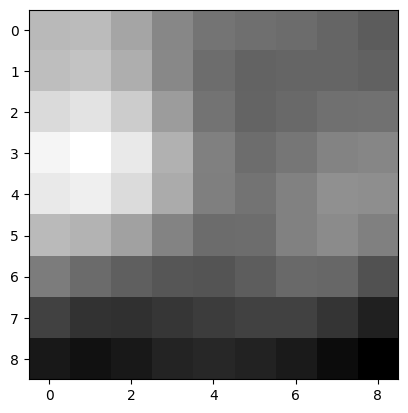

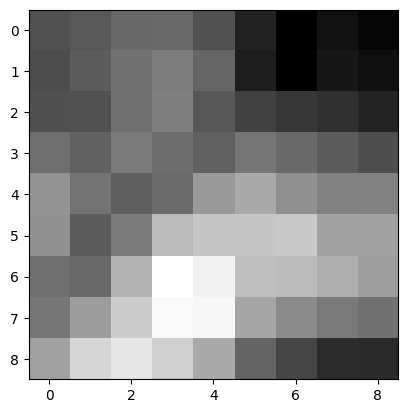

In [16]:
i = 60 
j = 60
k = 80

channel = 0

lr_patch = np.copy(subjects_lr[6][
                        i - p_size_i - e_or_o : i + p_size_i,
                        j - p_size_i - e_or_o : j + p_size_i,
                        k - p_size_i - e_or_o : k + p_size_i, :])

hr_patch = np.copy(subjects_hr[6][
                        i - p_size_o - e_or_o : i + p_size_o,
                        j - p_size_o - e_or_o : j + p_size_o,
                        k - p_size_o - e_or_o : k + p_size_o, :])

lr_mask = subjects_masks[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i]

lr_patch[lr_mask == 0] = 0

generated_image = generator(lr_patch[None,...], training=False)

print(discriminator(generated_image))

print(discriminator(hr_patch[None,...]))

plt.imshow(generated_image[0,:,:,3,channel],cmap='gray')
plt.figure()
plt.imshow(hr_patch[:,:,3,channel],cmap='gray')

In [17]:
# subjects_lr
# subjects_hr
# subjects_masks

result_image = np.zeros(hires_output.shape)

for (i, j, k) in tqdm(sel_indices[np.where(sel_indices[:,0]==6),1:].squeeze()):

    lr_patch = np.copy(subjects_lr[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i, :])

    lr_mask = subjects_masks[6][
                                i - p_size_i - e_or_o : i + p_size_i,
                                j - p_size_i - e_or_o : j + p_size_i,
                                k - p_size_i - e_or_o : k + p_size_i]

    lr_patch[lr_mask == 0] = 0

    generated_image = generator(lr_patch[None,...], training=False)

    result_image[i - p_size_o - e_or_o : i + p_size_o,
                 j - p_size_o - e_or_o : j + p_size_o,
                 k - p_size_o - e_or_o : k + p_size_o, :] = generated_image

result_image[subjects_masks[6] == 0] = 0
    

100%|██████████████████████████████████████| 1319/1319 [00:03<00:00, 401.95it/s]


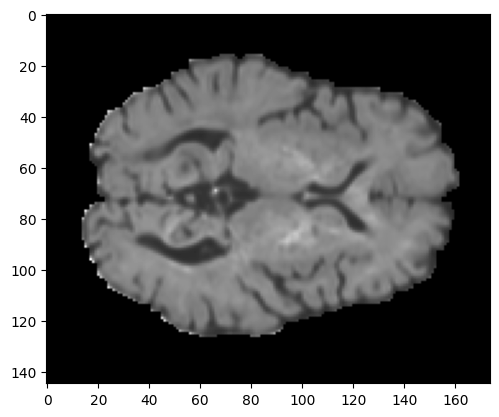

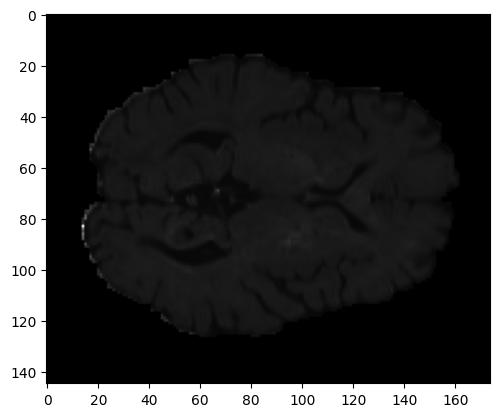

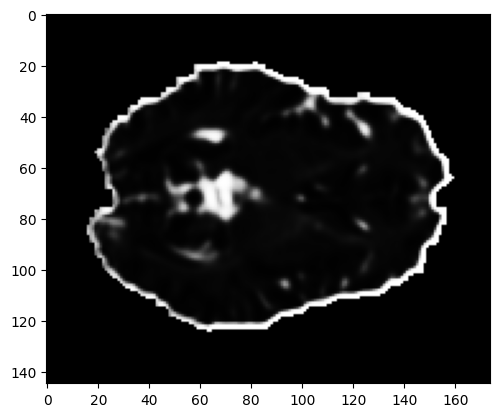

In [18]:
zdim = 60
channel = 0

# plt.imshow(subjects_masks[6][:,:,zdim], cmap='gray')
# plt.figure()
plt.imshow(subjects_lr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')
# plt.imshow((result_image[:,:,zdim,channel])*subjects_masks[6][:,:,zdim], cmap='gray')

0.38308292627334595 0.3753540515899658 0.004445801954716444


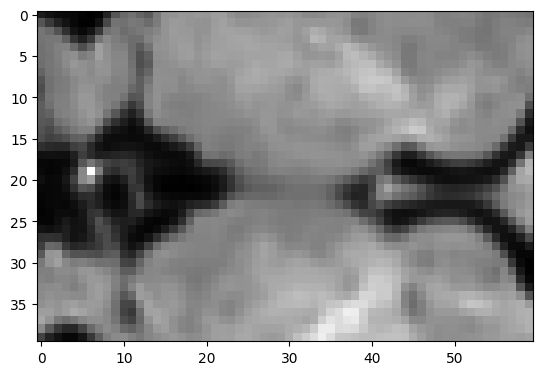

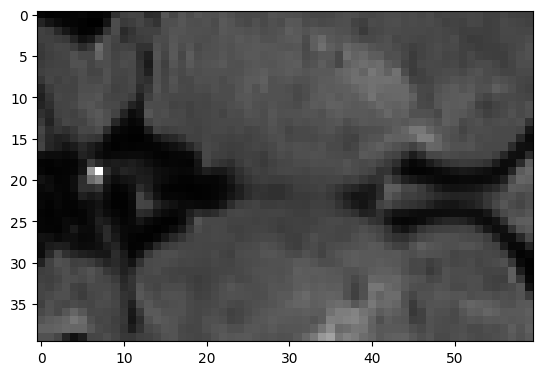

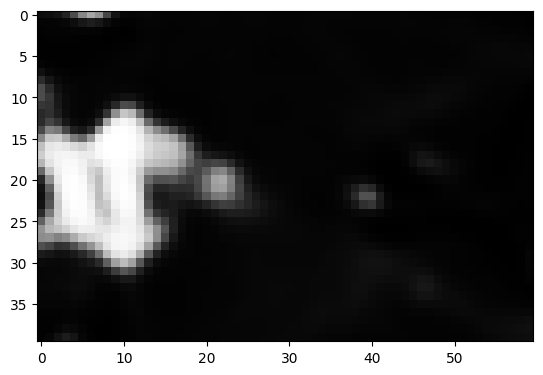

In [19]:
plt.imshow(subjects_lr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[50:90,60:120,zdim,channel], cmap='gray')

print(np.min(subjects_lr[6][40:80,60:120,zdim,channel]), np.min(subjects_hr[6][40:80,60:120,zdim,channel]), np.min(result_image[40:80,60:120,zdim,channel]))

In [20]:
# generator.save_weights('Model/gen_weights')
# discriminator.save_weights('Model/disc_weights')

In [21]:
generator.save('Model/generator{}x_dti_norm'.format(2*p_size_o + e_or_o))
discriminator.save('Model/discriminator{}x_dti_norm'.format(2*p_size_o + e_or_o))

INFO:tensorflow:Assets written to: Model/generator9x_dti_norm/assets


INFO:tensorflow:Assets written to: Model/generator9x_dti_norm/assets


INFO:tensorflow:Assets written to: Model/discriminator9x_dti_norm/assets


INFO:tensorflow:Assets written to: Model/discriminator9x_dti_norm/assets
